# Import des modules nécessaires

In [1]:
import requests
import re 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ACQUISITION ET CHARGEMENT DES DONNÉES

In [6]:
# on définit une fonction pour pouvoir extraire les données
def extract_url(url):
    
    Starturl = "https://www.vendeeglobe.org/download-race-data/vendeeglobe_"
    req = requests.get(url)
    html_doc = req.content
    soup = BeautifulSoup(html_doc, 'html.parser')
    tag = soup.findAll('option')
    Listeurl = []
    Listedate = []
    
    for list_tag in tag:
        for string in list_tag:
            dElement = re.sub('\D', '', string)
    
            if dElement == '':
                continue
                
            Listedate.append(string)
            
            Endurl = dElement[:8] + "_" + dElement[8:]
            Listeurl.append(Starturl + Endurl + ".xlsx")
            
    return Listeurl, Listedate

In [7]:
# On définit une fonction qui va télécharger chaque fichier 
def telechargement_url(url):
    Listeurl, Listedate = extract_url(url)
    
    for urls in Listeurl:
        nomExcel = urls[-32:]
        resp = requests.get(urls)
        with open(nomExcel, 'wb') as output:
            output.write(resp.content)

In [9]:
# On exécute notre fonction de téléchargement
telechargement_url("https://www.vendeeglobe.org/fr/classement")

# PREPARATION DES DONNEES

In [16]:
# fonction nécessaire à l'acquisition des longitudes et latitutes
def dms2dec(deg, mn, sec):
    return deg + mn/60 + sec/3600

def donnees_en_dataframe(url):
    Listeurl, Listedate = extract_url(url)
    
    predf = pd.DataFrame()
    for i in Listeurl:
        nomExcel = i[-32:]
        df = pd.read_excel(nomExcel, header = 4)
        df = df.drop(df.columns[[0]], axis='columns')
        df = df.dropna()
        df.columns = ['Rang', 'Nationalité / Voile', 'Skipper', 'Heure', 'Latitude', 'Longitude', 'depuis_30min_Cap','depuis_30min_Vitesse',
                      'depuis_30min_VMG','depuis_30min_Distance', 'depuis_derniereupdate_Cap','depuis_derniereupdate_Vitesse', 'depuis_derniereupdate_VMG',
                      'depuis_derniereupdate_Distance', 'depuis_24h_Cap', 'depuis_24h_Vitesse', 'depuis_24h_VMG', 'depuis_24h_Distance', 'DTF', 'DTL']
        df['Rang'] = df['Rang'].apply(lambda x : int(x))
        df['Skipper'] = df['Skipper'].apply(lambda x : x.split('\n')[0])
        df['Skipper'] = df['Skipper'].str.title()
        df = df.replace({'\n': ' '}, regex=True)
        predf = pd.concat([predf, df])
    df = predf
    
    df['depuis_30min_Vitesse'] = df['depuis_30min_Vitesse'].apply(lambda x : float(str(x)[0:-4]))
    df['depuis_30min_VMG'] = df['depuis_30min_VMG'].apply(lambda x : float(str(x)[0:-4]))
    df['depuis_24h_Vitesse'] = df['depuis_24h_Vitesse'].apply(lambda x : float(str(x)[0:-4]))
    df['depuis_24h_VMG'] = df['depuis_24h_VMG'].apply(lambda x : float(str(x)[0:-4]))
    df['depuis_derniereupdate_Vitesse'] = df['depuis_derniereupdate_Vitesse'].apply(lambda x : float(str(x)[0:-4]))
    df['depuis_derniereupdate_VMG'] = df['depuis_derniereupdate_VMG'].apply(lambda x : float(str(x)[0:-4]))
    df['depuis_30min_Cap'] = df['depuis_30min_Cap'].apply(lambda x : float(str(x)[0:-1]))
    df['depuis_derniereupdate_Cap'] = df['depuis_derniereupdate_Cap'].apply(lambda x : float(str(x)[0:-1]))
    df['depuis_24h_Cap'] = df['depuis_24h_Cap'].apply(lambda x : float(str(x)[0:-1]))
    df['depuis_30min_Distance'] = df['depuis_30min_Distance'].apply(lambda x : float(str(x)[0:-3]))
    df['depuis_derniereupdate_Distance'] = df['depuis_derniereupdate_Distance'].apply(lambda x : float(str(x)[0:-3]))
    df['depuis_24h_Distance'] = df['depuis_24h_Distance'].apply(lambda x : float(str(x)[0:-3]))
    df['Longitude'] = df['Longitude'].apply(lambda x : dms2dec(float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])) if 'N' in str(x) else dms2dec(-float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])))
    df['Latitude'] = df['Latitude'].apply(lambda x : dms2dec(float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])) if 'N' in str(x) else dms2dec(-float(str(x)[:str(x).find('°')]), float(str(x)[(str(x).find('°')+1):(str(x).find('°')+3)]), float(str(x)[(str(x).find('.')+1):(str(x).find('.')+3)])))
    df['DTF'] = df['DTF'].apply(lambda x : float(str(x)[0:-3]))
    df['DTL'] = df['DTL'].apply(lambda x : float(str(x)[0:-3]))
    df.reset_index(drop = True, inplace = True)
    
    return df

In [20]:
df1 = donnees_en_dataframe("https://www.vendeeglobe.org/fr/classement")
df1

,Rang,Nationalité / Voile,Skipper,Heure FR,Latitude,Longitude,depuis_30min_Cap,depuis_30min_Vitesse,depuis_30min_VMG,depuis_30min_Distance,depuis_derniereupdate_Cap,depuis_derniereupdate_Vitesse,depuis_derniereupdate_VMG,depuis_derniereupdate_Distance,depuis_24h_Cap,depuis_24h_Vitesse,depuis_24h_VMG,depuis_24h_Distance,DTF,DTL
0,25,FIN 222,Ari Huusela,04:30 FR,46.722500,-1.557778,128.0,11.4,11.3,1.0,115.0,8.9,8.9,62.2,84.0,6.7,6.7,161.5,30.6,0.0
1,25,FIN 222,Ari Huusela,21:30 FR,47.145556,-2.175000,107.0,8.7,8.6,4.4,94.0,9.1,8.8,36.5,68.0,7.1,6.9,170.9,92.7,0.0
2,25,FIN 222,Ari Huusela,17:30 FR,47.192500,-3.290000,94.0,10.0,9.7,5.0,94.0,8.7,8.5,26.1,62.0,7.2,6.9,172.2,127.4,0.0
3,25,FIN 222,Ari Huusela,14:30 FR,47.222778,-4.647500,106.0,6.7,6.7,3.4,69.0,3.5,2.9,10.5,62.0,7.4,7.1,178.8,152.8,0.0
4,25,FIN 222,Ari Huusela,11:30 FR,47.153056,-4.413611,19.0,5.7,0.5,2.8,28.0,7.6,2.8,22.7,66.0,8.2,7.9,196.5,161.4,0.0
5,25,FIN 222,Ari Huusela,08:30 FR,46.819167,-4.149722,26.0,8.9,3.1,4.5,37.0,8.1,5.2,32.4,73.0,8.7,8.7,209.9,168.5,0.0
6,25,FIN 222,Ari Huusela,04:30 FR,46.388056,-5.675000,56.0,8.7,7.5,4.4,67.0,8.4,8.1,58.6,80.0,9.5,9.5,229.1,187.3,0.0
7,25,FIN 222,Ari Huusela,21:30 FR,45.996667,-6.394722,54.0,9.1,8.1,4.6,69.0,8.4,8.2,33.4,84.0,10.3,10.3,248.0,243.0,0.0
8,25,FIN 222,Ari Huusela,17:30 FR,45.800833,-7.648889,78.0,10.6,10.6,5.3,87.0,10.7,10.7,32.2,86.0,10.7,10.6,257.4,275.8,0.0
9,25,FIN 222,Ari Huusela,14:30 FR,45.764444,-8.880833,85.0,10.1,10.1,5.1,86.0,10.3,10.3,31.0,87.0,10.5,10.3,250.8,307.8,0.0


## Webscraping des données des voiliers

In [22]:
def extract_donnees_voiliers(url):  
    r = requests.get(url)
    html_doc = r.content
    soup = BeautifulSoup(html_doc, 'html.parser')
    bateaux = soup.findAll("ul", {"class": "boats-list__popup-specs-list"})
    head = []
    
    for e in bateaux[0] :
        e = str(e)
        index = e.find(' : ')
        if(index != -1):
            head.append(e[4:index])
            
    donnees = []
    for element in bateaux:
        absent = []
        
        i = 0
        for h in head :
            if not(h in str(element)):
                absent.append(i)
            i+=1
        if len(absent) == len(head):
            continue
        row = []
        for spec in element :
            spec = str(spec)
            index = spec.find(' : ')
            if index != -1 :
                if len(row) in absent :
                    row.append(np.nan)
                    if len(row) in absent :
                        row.append(np.nan)
                row.append(spec[index+3:-5])
        donnees.append(row)
    df = pd.DataFrame(donnees, columns = head)
    
    bateaux_noms = soup.findAll("span", {"class": "boats-list__skipper-name"})
    names = []
    for name in bateaux_noms :
        name = str(name)
        indexMin = name.find('name">')
        indexMax = name.find('</span>')
        if(indexMin != -1 and indexMax != -1):
            if 'Alan' in name :
                names.append('Alan Roura')
            elif 'Arnaud' in name :
                names.append('Arnaud Boissieres')
            elif 'Sam' in name:
                names.append('Samantha Davies')
            else :
                names.append(name[indexMin+6:indexMax])
    df.insert(0, 'Skipper', names)
    df['Skipper'] = df['Skipper'].str.title()
    
    df['Longueur'] = df['Longueur'].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
    pd.to_numeric(df['Longueur'], errors='raise')
    df['Largeur'] = df['Largeur'].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
    pd.to_numeric(df['Largeur'], errors='raise')
    df["Tirant d'eau"] = df["Tirant d'eau"].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
    pd.to_numeric(df["Tirant d'eau"], errors='raise')
    df["Déplacement (poids)"] = df["Déplacement (poids)"].apply(lambda x : ((str(x).replace(',', '.')).replace('tonne', ''))[0:-1])
    pd.to_numeric(df["Déplacement (poids)"], errors='coerce')
    df["Hauteur mât"] = df["Hauteur mât"].apply(lambda x : ((str(x).replace(',', '.')).replace(' ', ''))[0:-1])
    pd.to_numeric(df["Hauteur mât"], errors='raise')
    df["Surface de voiles au près"] = df["Surface de voiles au près"].apply(lambda x : ((str(x).replace(',', '.')).replace(' ', ''))[0:-2])
    pd.to_numeric(df["Surface de voiles au près"], errors='raise')
    df["Surface de voiles au portant"] = df["Surface de voiles au portant"].apply(lambda x : (str(x).replace(',', '.'))[0:-2])
    pd.to_numeric(df["Surface de voiles au portant"], errors='raise')

    return df

In [23]:
df2 = extract_donnees_voiliers("https://www.vendeeglobe.org/fr/glossaire")
df2

,Skipper,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice Amedeo,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.50,7,foils,29,monotype,320,570
1,Romain Attanasio,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18.28,5.80,4.50,9,2,28,acier forgé,280,560
2,Alexia Barrier,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.50,9,2,29,acier,260,580
3,Yannick Bestaven,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.80,4.50,8,foils,29,acier mécano soudé,310,550
4,Jérémie Beyou,08,NaN,VPLP,CDK Technologies,18 Août 2018,18.28,5.85,4.50,8,foils,29,acier,320,600
5,Arnaud Boissieres,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,18.28,5.65,4.50,7.9,foils,29,basculante avec vérin,300,610
6,Louis Burton,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,18.28,5.80,4.50,7.6,foils,28,acier,300,600
7,Didac Costa,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,02 Février 2000,18.28,5.30,4.50,8.9,2,26,acier,240,470
8,Manuel Cousin,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,18.28,5.80,4.50,9,2 asymétriques,28.5,basculante sur vérin hydraulique,270,560
9,Clarisse Cremer,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,18.28,5.70,4.5,7.7,2,29,acier forgé,340,570


## On procède à la jointure entre les deux dataframes

In [38]:
df_final = pd.merge(df1,
                    df2,
                    on='Skipper',
                    how='outer', left_on=None, right_on=None)

df_final.reset_index(drop = True, inplace = True)

In [39]:
df_final

,Rang,Nationalité / Voile,Skipper,Heure FR,Latitude,Longitude,depuis_30min_Cap,depuis_30min_Vitesse,depuis_30min_VMG,depuis_30min_Distance,depuis_derniereupdate_Cap,depuis_derniereupdate_Vitesse,depuis_derniereupdate_VMG,depuis_derniereupdate_Distance,depuis_24h_Cap,depuis_24h_Vitesse,depuis_24h_VMG,depuis_24h_Distance,DTF,DTL,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,25,FIN 222,Ari Huusela,04:30 FR,46.722500,-1.557778,128.0,11.4,11.3,1.0,115.0,8.9,8.9,62.2,84.0,6.7,6.7,161.5,30.6,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580
1,25,FIN 222,Ari Huusela,21:30 FR,47.145556,-2.175000,107.0,8.7,8.6,4.4,94.0,9.1,8.8,36.5,68.0,7.1,6.9,170.9,92.7,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580
2,25,FIN 222,Ari Huusela,17:30 FR,47.192500,-3.290000,94.0,10.0,9.7,5.0,94.0,8.7,8.5,26.1,62.0,7.2,6.9,172.2,127.4,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580
3,25,FIN 222,Ari Huusela,14:30 FR,47.222778,-4.647500,106.0,6.7,6.7,3.4,69.0,3.5,2.9,10.5,62.0,7.4,7.1,178.8,152.8,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580
4,25,FIN 222,Ari Huusela,11:30 FR,47.153056,-4.413611,19.0,5.7,0.5,2.8,28.0,7.6,2.8,22.7,66.0,8.2,7.9,196.5,161.4,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580
5,25,FIN 222,Ari Huusela,08:30 FR,46.819167,-4.149722,26.0,8.9,3.1,4.5,37.0,8.1,5.2,32.4,73.0,8.7,8.7,209.9,168.5,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580
6,25,FIN 222,Ari Huusela,04:30 FR,46.388056,-5.675000,56.0,8.7,7.5,4.4,67.0,8.4,8.1,58.6,80.0,9.5,9.5,229.1,187.3,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580
7,25,FIN 222,Ari Huusela,21:30 FR,45.996667,-6.394722,54.0,9.1,8.1,4.6,69.0,8.4,8.2,33.4,84.0,10.3,10.3,248.0,243.0,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580
8,25,FIN 222,Ari Huusela,17:30 FR,45.800833,-7.648889,78.0,10.6,10.6,5.3,87.0,10.7,10.7,32.2,86.0,10.7,10.6,257.4,275.8,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580
9,25,FIN 222,Ari Huusela,14:30 FR,45.764444,-8.880833,85.0,10.1,10.1,5.1,86.0,10.3,10.3,31.0,87.0,10.5,10.3,250.8,307.8,0.0,FIN222,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.50,8.5,2,28,acier,270,580


# Exploitation des données

## Série temporelles

On se propose ici d'observer le classement de 5 personnes au cours de la course

In [51]:
df3['Rang'] = df3['Rang'].apply(pd.to_numeric)
df3.sort_values(by=['DTF'], ascending=False, inplace=True)

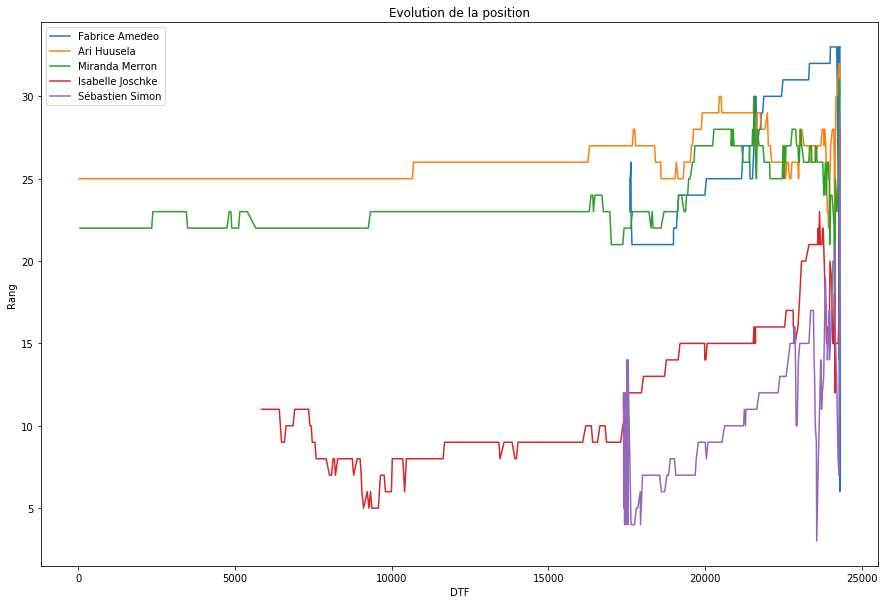

In [53]:
skipper = df["Skipper"].unique()
    
plt.subplots(figsize=(15, 10))
plt.title("Evolution de la position")
    
for s in skipper[:5]:
    rang = df3['Rang'].loc[(df3["Skipper"] == s)]
    Dtf = df3['DTF'].loc[(df3["Skipper"] == s)]
    plt.plot(Dtf, rang, label = s)
    
plt.xlabel("DTF")
plt.ylabel("Rang")
plt.legend() 

A l'aide de ce graphe, on peut s'apercevoir que Sébastien Simon a du abandonné la course tout comme Isabelle Joschke et Fabrice Amedeo.